In [23]:
# basic package
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# usual torch package
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# here i running the code in kaggle runtime
print(os.listdir("/kaggle/input/skin-cancer-mnist-ham10000"))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [3]:
# reading metadata
metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# joining dir 
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

# make "path" columns
metadata['path'] = metadata['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg") if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

In [7]:
metadata.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
6427,HAM_0003705,ISIC_0025263,nv,follow_up,50.0,male,trunk,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1051,HAM_0001062,ISIC_0027710,bkl,consensus,50.0,male,trunk,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
7069,HAM_0005060,ISIC_0031975,nv,histo,75.0,male,upper extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2574,HAM_0006548,ISIC_0030010,bcc,histo,65.0,female,neck,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
5246,HAM_0000115,ISIC_0030745,nv,follow_up,75.0,male,back,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4623,HAM_0005839,ISIC_0027366,nv,follow_up,45.0,male,back,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
5588,HAM_0004451,ISIC_0027992,nv,follow_up,55.0,female,trunk,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
6695,HAM_0006032,ISIC_0028791,nv,histo,30.0,male,lower extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
448,HAM_0006170,ISIC_0027969,bkl,histo,70.0,female,face,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1082,HAM_0002742,ISIC_0025654,bkl,consensus,70.0,female,back,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [4]:
# just to see target distribution
metadata.dx.value_counts(normalize=True)

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: proportion, dtype: float64

In [5]:
# Little bit transformation&augmentation for feature enrichment
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Build custom dataset&dataloader

In [8]:
class CancerDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.metadata.iloc[idx]['dx']

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
# holdout splitting configuration 80 train:20 test
train_metadata, test_metadata = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata['dx'])

In [10]:
# dataset
train_dataset = CancerDataset(train_metadata, transform=train_transform)
test_dataset = CancerDataset(test_metadata, transform=val_transform)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# encoding for target data
le = LabelEncoder()
train_metadata['dx'] = le.fit_transform(train_metadata['dx'])
test_metadata['dx'] = le.transform(test_metadata['dx'])

## Function to initialize Optim & Criterion

In [12]:
def optim_criterion(model):
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    return optimizer, criterion

## Model loading -> `mobilenetV2`

In [13]:
# pretrained phase with ImageNet data
mobnet_model = models.mobilenet_v2(pretrained=True)
# customize final layer and our output task 
num_ftrs = mobnet_model.classifier[1].in_features 
mobnet_model.classifier[1] = nn.Linear(num_ftrs, len(le.classes_))
# move model to gpu device 
mobnet_model.to(device)
mobnet_optimizer, mobnet_criterion = optim_criterion(mobnet_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


In [25]:
mobnet_optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0.01
)

In [26]:
mobnet_criterion

CrossEntropyLoss()

## Model loading -> `EfficientNet`

In [14]:
# pretrained phase with ImageNet data
effnet_model = models.efficientnet_b0(pretrained=True)
# customize final layer and our output task 
num_ftrs = effnet_model.classifier[1].in_features
effnet_model.classifier[1] = nn.Linear(num_ftrs, len(le.classes_))
# move model to gpu device 
effnet_model.to(device)
effnet_optimizer, effnet_criterion = optim_criterion(effnet_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 83.9MB/s]


## Model loading -> `CNN+Transformers Encoder`

In [15]:
class CNN1DTransformerClassifier(nn.Module):
    def __init__(self, cnn_out_channels, transformer_hidden_dim, transformer_nhead, transformer_num_layers, output_dim, dropout=0.1):
        super(CNN1DTransformerClassifier, self).__init__()
        # cnn 
        self.cnn = nn.Conv1d(in_channels=3, out_channels=cnn_out_channels, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(cnn_out_channels, transformer_hidden_dim)
        
        # transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_hidden_dim, nhead=transformer_nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_num_layers)
        
        self.fc2 = nn.Linear(transformer_hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, 3, 224, 224)
        batch_size = x.size(0)
        
        # Transform image to 1D by reshaping
        x = x.view(batch_size, 3, -1)  # shape: (batch_size, 3, 224*224)
        
        # CNN layer
        x = self.cnn(x)  # shape: (batch_size, cnn_out_channels, 224*224)
        x = self.pool(x)  # shape: (batch_size, cnn_out_channels, 1)
        x = x.view(batch_size, -1)  # shape: (batch_size, cnn_out_channels)
        
        x = self.fc1(x)  # shape: (batch_size, transformer_hidden_dim)
        x = x.unsqueeze(1)  # shape: (batch_size, 1, transformer_hidden_dim)

        # Transformer layer
        x = self.transformer(x)  # shape: (batch_size, 1, transformer_hidden_dim)
        x = x.squeeze(1)  # shape: (batch_size, transformer_hidden_dim)
        
        x = self.fc2(self.dropout(x))  # shape: (batch_size, output_dim)
        
        return x

#### initialize model params for CNN+Transformer

In [16]:
# Transformer Model Parameters
CNN_OUT_CHANNELS = 64
TRANSFORMER_HIDDEN_DIM = 128
TRANSFORMER_NHEAD = 8
TRANSFORMER_NUM_LAYERS = 2
OUTPUT_DIM = len(le.classes_)
DROPOUT = 0.25

In [17]:
cnn_trans_model = CNN1DTransformerClassifier(CNN_OUT_CHANNELS, TRANSFORMER_HIDDEN_DIM, TRANSFORMER_NHEAD, TRANSFORMER_NUM_LAYERS, OUTPUT_DIM, DROPOUT)
cnn_trans_model.to(device)
cnn_trans_optimizer, cnn_trans_criterion = optim_criterion(cnn_trans_model)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Train&Eval loop 🔃

In [32]:
def train_eval(model, data_loader, criterion, optimizer, device, phase):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    cost = []
    correct_preds = 0

    loop = tqdm(data_loader,leave=False)
    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device)

        if phase == 'train':
            optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase=='train'):
            # feed forward
            outputs = model(inputs)
            # loss calculation
            loss = criterion(outputs, labels)
            _,preds = torch.max(outputs,dim=1)

            if phase == 'train':
                    # backprop 
                    loss.backward()
                    optimizer.step()

        correct_preds += torch.sum(preds==labels)
        # acummulate loss put it to cost
        cost.append(loss.item())

        loop.set_postfix(loss=np.mean(cost), accuracy=correct_preds.double() / len(data_loader.dataset))

    return correct_preds.double() / len(data_loader.dataset), np.mean(cost)

# Training Loop

###  `mobilenetV2`....

In [33]:
epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_acc, train_loss = train_eval(mobnet_model, train_loader, mobnet_criterion, mobnet_optimizer, device, phase='train')
    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')

Epoch 1/10


Train loss: 1.1425, accuracy: 0.6266
Epoch 2/10


Train loss: 0.7797, accuracy: 0.7300
Epoch 3/10


Train loss: 0.7180, accuracy: 0.7465
Epoch 4/10


Train loss: 0.6651, accuracy: 0.7594
Epoch 5/10


Train loss: 0.6432, accuracy: 0.7676
Epoch 6/10


Train loss: 0.6194, accuracy: 0.7797
Epoch 7/10


Train loss: 0.5987, accuracy: 0.7851
Epoch 8/10


Train loss: 0.5738, accuracy: 0.7912
Epoch 9/10


Train loss: 0.5585, accuracy: 0.7986
Epoch 10/10


Train loss: 0.5455, accuracy: 0.7996


###  `EfficientNet`....

In [36]:
epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_acc, train_loss = train_eval(effnet_model, train_loader, effnet_criterion, effnet_optimizer, device, phase='train')
    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')

Epoch 1/10


Train loss: 1.3761, accuracy: 0.5976
Epoch 2/10


Train loss: 0.9297, accuracy: 0.7008
Epoch 3/10


Train loss: 0.8391, accuracy: 0.7161
Epoch 4/10


Train loss: 0.7775, accuracy: 0.7327
Epoch 5/10


Train loss: 0.7336, accuracy: 0.7449
Epoch 6/10


Train loss: 0.7011, accuracy: 0.7505
Epoch 7/10


Train loss: 0.6765, accuracy: 0.7607
Epoch 8/10


Train loss: 0.6398, accuracy: 0.7787
Epoch 9/10


Train loss: 0.6351, accuracy: 0.7738
Epoch 10/10


Train loss: 0.6081, accuracy: 0.7803


###  `CNN+Transformer Encoder`....

In [37]:
epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_acc, train_loss = train_eval(cnn_trans_model, train_loader, cnn_trans_criterion, cnn_trans_optimizer, device, phase='train')
    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')

Epoch 1/10


Train loss: 1.1823, accuracy: 0.6635
Epoch 2/10


Train loss: 1.1472, accuracy: 0.6695
Epoch 3/10


Train loss: 1.1247, accuracy: 0.6696
Epoch 4/10


Train loss: 1.1093, accuracy: 0.6684
Epoch 5/10


Train loss: 1.0958, accuracy: 0.6676
Epoch 6/10


Train loss: 1.0874, accuracy: 0.6643
Epoch 7/10


Train loss: 1.0777, accuracy: 0.6658
Epoch 8/10


Train loss: 1.0758, accuracy: 0.6659
Epoch 9/10


Train loss: 1.0635, accuracy: 0.6651
Epoch 10/10


Train loss: 1.0627, accuracy: 0.6656


# Evaluating on data test

In [42]:
print("Evaluating with mobilenetV2...")
test_acc, test_loss = train_eval(mobnet_model, test_loader, mobnet_criterion, mobnet_optimizer, device, phase='test')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Evaluating with mobilenetV2...


Test loss: 0.5705, accuracy: 0.7988


In [41]:
print("Evaluating with EfficientNet...")
test_acc, test_loss = train_eval(effnet_model, test_loader, effnet_criterion, effnet_optimizer, device, phase='test')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Evaluating with EfficientNet...


Test loss: 0.5447, accuracy: 0.8088


In [44]:
print("Evaluating with CNN+Transformer Encoder...")
test_acc, test_loss = train_eval(cnn_trans_model, test_loader, cnn_trans_criterion, cnn_trans_optimizer, device, phase='test')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Evaluating with CNN+Transformer Encoder...


Test loss: 1.0261, accuracy: 0.6680


## Get predictions

In [45]:
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

Classification Report:
              precision    recall  f1-score   support

       akiec       0.66      0.48      0.55        65
         bcc       0.72      0.77      0.75       103
         bkl       0.74      0.46      0.57       220
          df       0.40      0.09      0.14        23
         mel       0.85      0.21      0.34       223
          nv       0.81      0.99      0.89      1341
        vasc       0.95      0.64      0.77        28

    accuracy                           0.80      2003
   macro avg       0.73      0.52      0.57      2003
weighted avg       0.80      0.80      0.76      2003



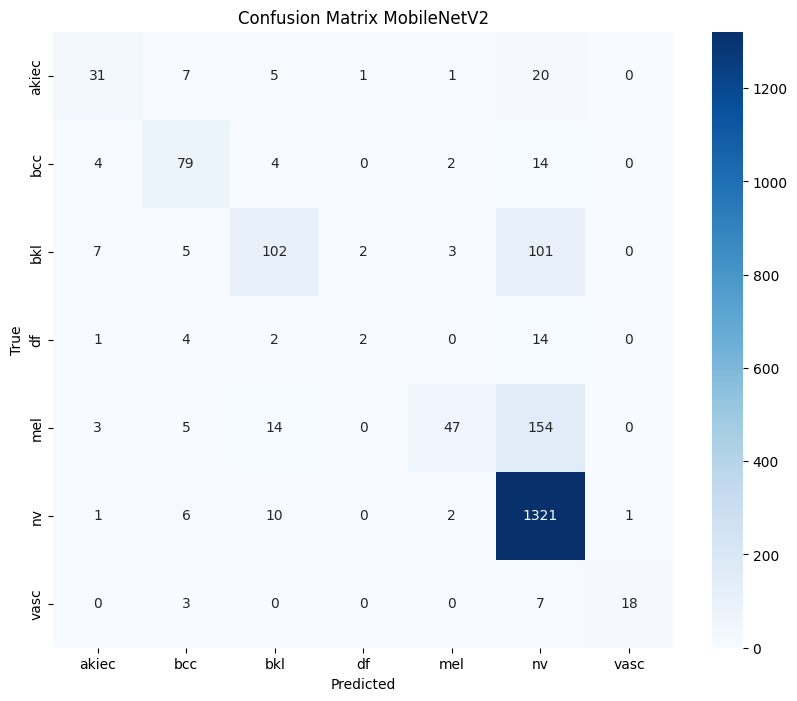

In [49]:
# get original predict&labels
predictions, true_labels = get_predictions(mobnet_model, test_loader, device)

# class report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=le.classes_))

# conf mat
conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix MobileNetV2')
plt.show()

Classification Report:
              precision    recall  f1-score   support

       akiec       0.50      0.45      0.47        65
         bcc       0.69      0.82      0.75       103
         bkl       0.68      0.47      0.56       220
          df       0.00      0.00      0.00        23
         mel       0.73      0.32      0.45       223
          nv       0.85      0.98      0.91      1341
        vasc       0.70      0.68      0.69        28

    accuracy                           0.81      2003
   macro avg       0.59      0.53      0.55      2003
weighted avg       0.79      0.81      0.78      2003



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


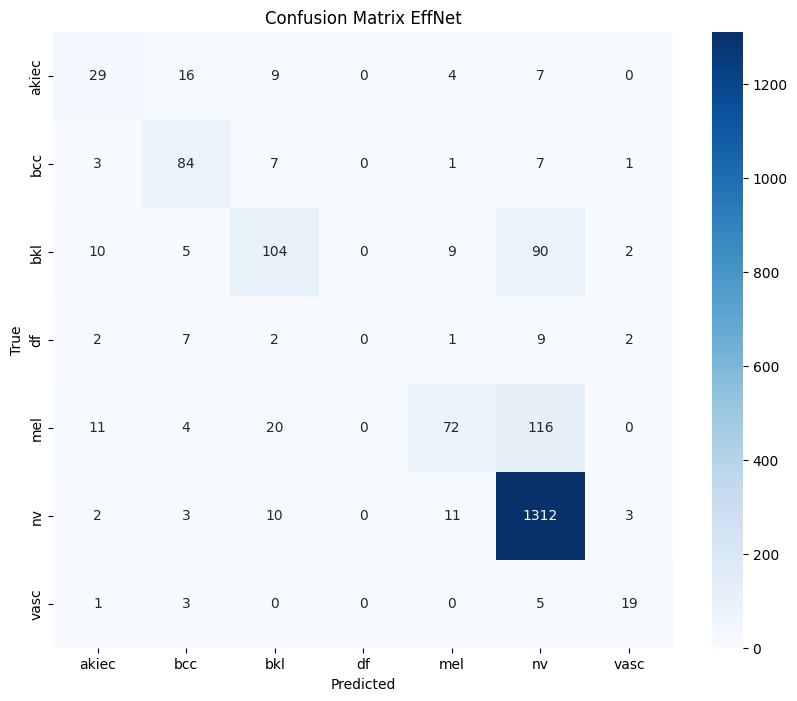

In [47]:
predictions, true_labels = get_predictions(effnet_model, test_loader, device)

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=le.classes_))

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix EffNet')
plt.show()

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.20      0.00      0.01       223
          nv       0.67      1.00      0.80      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.67      2003
   macro avg       0.12      0.14      0.12      2003
weighted avg       0.47      0.67      0.54      2003



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


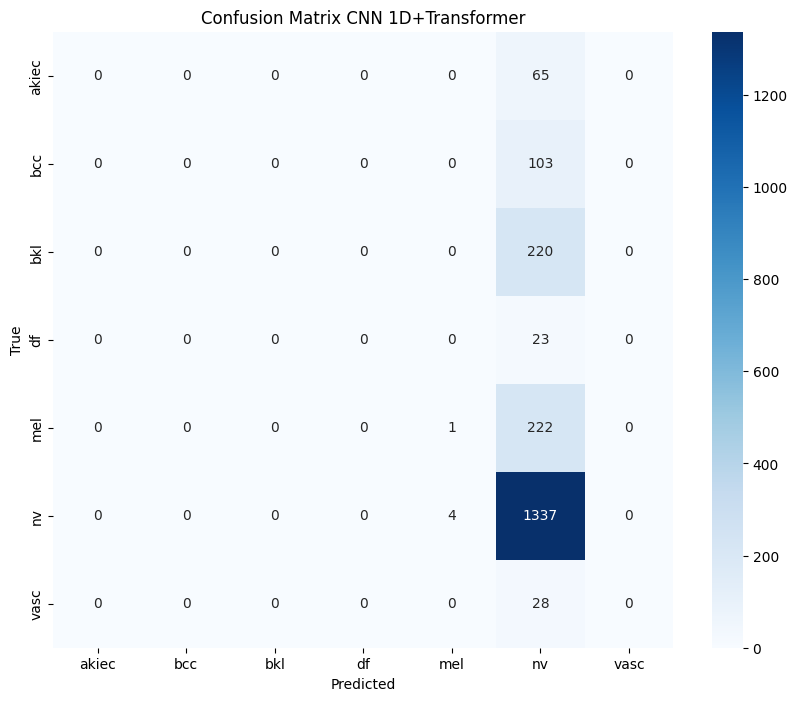

In [48]:
predictions, true_labels = get_predictions(cnn_trans_model, test_loader, device)

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=le.classes_))

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix CNN 1D+Transformer')
plt.show()

## ConvXnet Legend 🚀🚀🚀

In [51]:
# Load a pre-trained ConvNeXt model and modify it for your dataset
convnext_model = models.convnext_base(pretrained=True)

# Modify the final layer for the number of classes in your dataset
num_ftrs = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Linear(num_ftrs, len(le.classes_))  # Replace len(le.classes_) with your number of classes
convnext_model.to(device)
convnext_optimizer, convnext_criterion = optim_criterion(convnext_model)

In [52]:
epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_acc, train_loss = train_eval(convnext_model, train_loader, convnext_criterion, convnext_optimizer, device, phase='train')
    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')

Epoch 1/10


Train loss: 0.9071, accuracy: 0.6962
Epoch 2/10


Train loss: 0.6912, accuracy: 0.7515
Epoch 3/10


Train loss: 0.5958, accuracy: 0.7918
Epoch 4/10


Train loss: 0.5388, accuracy: 0.8105
Epoch 5/10


Train loss: 0.4959, accuracy: 0.8238
Epoch 6/10


Train loss: 0.4550, accuracy: 0.8416
Epoch 7/10


Train loss: 0.4326, accuracy: 0.8476
Epoch 8/10


Train loss: 0.4114, accuracy: 0.8577
Epoch 9/10


Train loss: 0.3829, accuracy: 0.8615
Epoch 10/10


Train loss: 0.3570, accuracy: 0.8704


In [54]:
print("Evaluating with ConvNeXT...")
test_acc, test_loss = train_eval(convnext_model, test_loader, convnext_criterion, convnext_optimizer, device, phase='test')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Evaluating with ConvNeXT...


Test loss: 0.3966, accuracy: 0.8612


Classification Report:
              precision    recall  f1-score   support

       akiec       0.66      0.66      0.66        65
         bcc       0.84      0.83      0.84       103
         bkl       0.80      0.67      0.73       220
          df       0.58      0.48      0.52        23
         mel       0.83      0.41      0.55       223
          nv       0.88      0.99      0.93      1341
        vasc       0.96      0.82      0.88        28

    accuracy                           0.86      2003
   macro avg       0.79      0.69      0.73      2003
weighted avg       0.86      0.86      0.85      2003



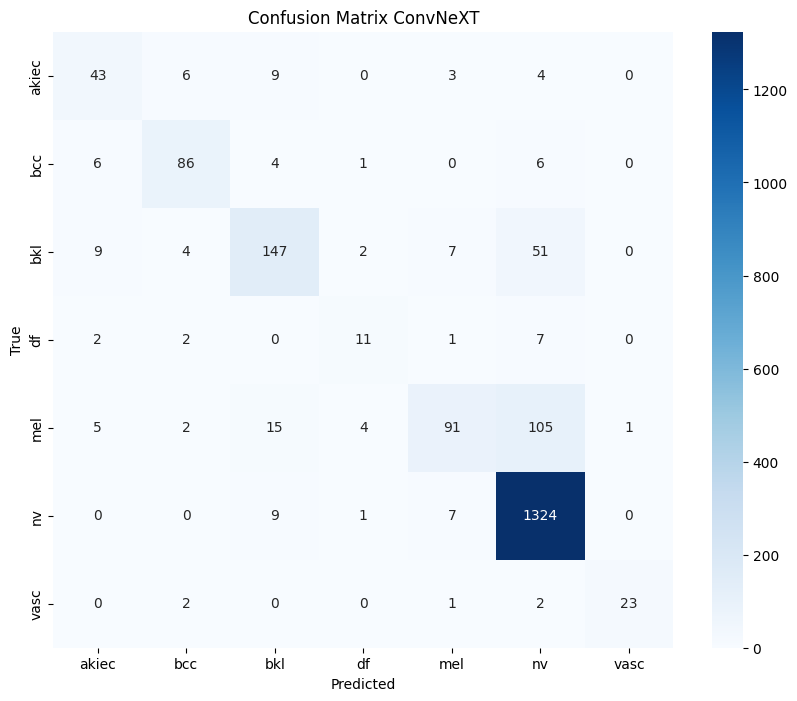

In [55]:
predictions, true_labels = get_predictions(convnext_model, test_loader, device)

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=le.classes_))

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix ConvNeXT')
plt.show()